# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Predictions with ML Regression Models (T4) - train_features.csv & train_salaries.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [4]:
# Last 5 rows of the dataset
df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


## Prepare Train and Test Sets

In [5]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


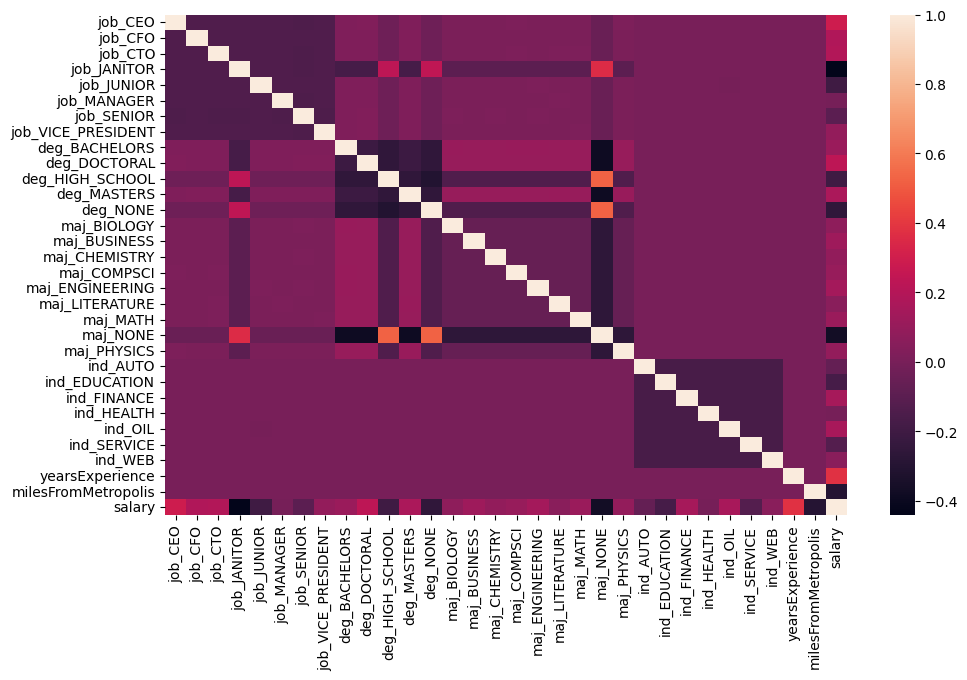

#### CORRELATION VALUES AGAINST SALARIES ####
job_CEO                0.285245
job_CFO                0.188804
job_CTO                0.189600
job_JANITOR           -0.441660
job_JUNIOR            -0.201993
job_MANAGER           -0.006781
job_SENIOR            -0.103642
job_VICE_PRESIDENT     0.090941
deg_BACHELORS          0.111923
deg_DOCTORAL           0.231391
deg_HIGH_SCHOOL       -0.203543
deg_MASTERS            0.171992
deg_NONE              -0.257349
maj_BIOLOGY            0.076341
maj_BUSINESS           0.126124
maj_CHEMISTRY          0.084046
maj_COMPSCI            0.102987
maj_ENGINEERING        0.144176
maj_LITERATURE         0.053920
maj_MATH               0.110401
maj_NONE              -0.371421
maj_PHYSICS            0.092057
ind_AUTO              -0.069913
ind_EDUCATION         -0.175148
ind_FINANCE            0.154847
ind_HEALTH            -0.003439
ind_OIL                0.156959
ind_SERVICE           -0.122361
ind_WEB                0.058949
yearsExperience        0.3

In [6]:
# Show the correlations of all concatenated columns in a heat map
plt.figure(figsize=(11,6.5))
sns.heatmap(df_concat.corr())
plt.show()
print("#### CORRELATION VALUES AGAINST SALARIES ####")
print(df_concat.corr()['salary'])

### Type 4: Use Most Negatively & Positively Correlated Columns Only

In [7]:
# Use 80% of the dataset as train set, and 20% as test set
# X = df_concat.drop(columns='salary', axis=1)
X = df_concat[['job_CEO','job_CFO','job_CTO','job_JANITOR','deg_DOCTORAL','deg_HIGH_SCHOOL','deg_NONE','maj_NONE',
               'yearsExperience','milesFromMetropolis']]
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)
print(X.columns)

TRAIN SIZE: (800000, 10) (800000,)   TEST SIZE: (200000, 10) (200000,)
Index(['job_CEO', 'job_CFO', 'job_CTO', 'job_JANITOR', 'deg_DOCTORAL',
       'deg_HIGH_SCHOOL', 'deg_NONE', 'maj_NONE', 'yearsExperience',
       'milesFromMetropolis'],
      dtype='object')


In [8]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [9]:
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [10]:
# Fit the training data into the linear reg. model, then make predictions on the test data
s_time = time.time()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.410 seconds.


In [11]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [ 34.80109516  25.04945604  25.03266717 -27.55675623   7.54822343
  -8.14919829 -11.89514382  -8.36071122   2.01082409  -0.40046142]
RANK: 10
INTERCEPT: 112.51999510562813


In [12]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  105.18962623738572 |       73
   127.5693731367383 |      100
  101.20204594571105 |      101
  107.08499936273577 |      112
  117.60017733304346 |      130
  116.94969685539557 |      108
  102.31205702783963 |      130
   58.11798510368295 |       43
  176.24707459597226 |      174
  104.48239006746232 |       88
  112.46606762141653 |      103
  165.92522808505328 |      162
   96.09163496197726 |       73
  117.56341392071161 |       96
  126.39329470417941 |      121
    157.795401590417 |      187
   153.7497305169538 |      173
   90.80408710131132 |       89
  113.72045455727347 |      106
  110.11630174767751 |      160


In [13]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-linreg.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 587.750573670536
RMSE: 24.24356767620096
MAE: 19.4349355702564
R2 SCORE: 0.6095650743465792
ADJUSTED R2 SCORE: 0.6083301133185046

# CROSS VALIDATION #
FITTING TIME: [0.42424273 0.39798045 0.46333528 0.40596747 0.39201069] -> 0.41670732498168944
SCORING TIME: [0.02555537 0.01505423 0.01570582 0.02329493 0.01251721] -> 0.018425512313842773
TRAIN SCORE: [0.60838964 0.60844518 0.60871818 0.60816201 0.60796385] -> 0.6083357721770027
TEST SCORE: [0.6081064  0.60788637 0.60679042 0.6090193  0.60981384] -> 0.6083232661212777


## 2 - Lasso Regression

In [14]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [15]:
# Fit the training data into the lasso model, then make predictions on the test data
s_time = time.time()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.359 seconds.


In [16]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)   

COEF: [ 22.79255385  12.99753553  13.03501961 -26.22769143   3.34264817
  -0.          -1.77049185 -15.24006278   1.99262909  -0.39889732]
INTERCEPT: 117.0606090075915
ITERATIONS: 10


In [17]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  112.79062094030773 |       73
  121.21191773808054 |      100
  108.79793268650329 |      101
  113.84613229093361 |      112
  111.19642805588407 |      130
  117.19350342581377 |      108
   94.99266430321336 |      130
   65.20480676695415 |       43
  164.30393376480802 |      174
  111.97239359896372 |       88
  119.95591258859308 |      103
   165.8329714318137 |      162
   96.45827276493603 |       73
  110.10956341142224 |       96
  119.97588417110295 |      121
   151.3057853184865 |      187
  145.97874456637837 |      173
   96.63488104538145 |       89
   114.0078974054761 |      106
  110.41782150941526 |      160


In [18]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-lasso.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 638.58731988839
RMSE: 25.270285314740512
MAE: 20.296736533332815
R2 SCORE: 0.5757948967930722
ADJUSTED R2 SCORE: 0.5753003480762942

# CROSS VALIDATION #
FITTING TIME: [0.40174174 0.38688803 0.40986681 0.39038754 0.38686275] -> 0.39514937400817873
SCORING TIME: [0.01525068 0.02173996 0.02938628 0.01580834 0.01608729] -> 0.019654512405395508
TRAIN SCORE: [0.57556034 0.57558043 0.57592332 0.57536225 0.5751278 ] -> 0.5755108281524859
TEST SCORE: [0.57595323 0.57478468 0.57357806 0.57540635 0.57777342] -> 0.5754991476391591


## 3 - Ridge Regression

In [19]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
# Fit the training data into the ridge model, then make predictions on the test data
s_time = time.time()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.123 seconds.


In [21]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 34.80060291  25.04906109  25.03227373 -27.55663628   7.54821361
  -8.14899027 -11.89491631  -8.36093721   2.01082408  -0.40046142]
INTERCEPT: 112.52015835851273
ITERATIONS: None


In [22]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  105.18979108237329 |       73
  127.56912514661813 |      100
  101.20221087660002 |      101
  107.08526450730432 |      112
  117.59992801498406 |      130
  116.94985050793547 |      108
  102.31182727896241 |      130
   58.11825061926847 |       43
   176.2467358446103 |      174
  104.48255512150155 |       88
  112.46623252175401 |      103
  165.92538138467722 |      162
   96.09178880054901 |       73
  117.56318251268877 |       96
   126.3930452405795 |      121
  157.79505461280522 |      187
   153.7494989693559 |      173
   90.80423244101927 |       89
  113.72060819526955 |      106
  110.11645543040292 |      160


In [23]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-ridge.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 587.7506244724062
RMSE: 24.243568723940093
MAE: 19.434938350934267
R2 SCORE: 0.6095650405995694
ADJUSTED R2 SCORE: 0.608330106512157

# CROSS VALIDATION #
FITTING TIME: [0.16829967 0.15904689 0.17283154 0.17296648 0.16820812] -> 0.16827054023742677
SCORING TIME: [0.01551604 0.01572061 0.01786351 0.01570106 0.01564097] -> 0.016088438034057618
TRAIN SCORE: [0.60838964 0.60844518 0.60871818 0.60816201 0.60796385] -> 0.6083357721412366
TEST SCORE: [0.60810641 0.60788636 0.6067904  0.60901929 0.60981387] -> 0.6083232663187984


## 4 - Polynomial Regression

In [24]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [25]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(800000, 66) (200000, 66)


### Polynomial Regression with Lasso

In [26]:
lasso = Lasso(max_iter=500)
s_time = time.time()
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 7.923 seconds.


In [27]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)  

COEF: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.36626952e+00  2.64757273e+00 -1.68543965e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.12166087e+00
  3.18074860e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.68026787e-01  2.33897445e-01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  7.69553579e-01  2.35008231e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -9.42003988e-01
 -2.47050783e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.64653800e-01  6.51435344e-02 -0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -1.02381071e-01 -9.80100753e-02
 -0.00000000e+00 -0.00000000e+00 -2.21787472e-01 -1.33881823e-01
 -1.27851476e+00 -2

In [28]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 650.996947666594
RMSE: 25.514641829086962
MAE: 20.517672648285696
R2 SCORE: 0.5675513453343106

# CROSS VALIDATION #
FITTING TIME: [0.53792763 0.53773355 0.52658606 0.39745808 0.49308181] -> 0.49855742454528806
SCORING TIME: [0.00911617 0.03466606 0.01566005 0.02478218 0.00976515] -> 0.018797922134399413
TRAIN SCORE: [0.57556034 0.57558043 0.57592332 0.57536225 0.5751278 ] -> 0.5755108281524859
TEST SCORE: [0.57595323 0.57478468 0.57357806 0.57540635 0.57777342] -> 0.5754991476391591


### Polynomial Regression with Ridge

In [29]:
ridge = Ridge(max_iter=2000)
s_time = time.time()
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.608 seconds.


In [30]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 0.00000000e+00  1.72640361e+01  1.25740326e+01  1.23747367e+01
 -7.90118277e+00  3.61634121e+00 -2.50480380e+00 -4.09095616e+00
 -4.37993325e+00  2.98871179e+00 -1.72395209e-01  1.72640361e+01
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.95733928e-01
 -1.53423668e-01 -1.69727411e-01  8.84045728e-02  2.02094647e-02
  2.20389480e-03  1.25740326e+01  0.00000000e+00  0.00000000e+00
  1.72611654e-01  1.23899708e-01  2.16945282e-01 -1.50189081e-01
 -1.26046835e-02 -3.12293688e-05  1.23747367e+01  0.00000000e+00
 -2.05348317e-01 -2.90904005e-01 -4.66633357e-01  1.92860441e-01
  8.55236485e-03  5.47394411e-03 -7.90118277e+00  0.00000000e+00
 -6.35283168e+00 -1.54835094e+00 -7.90118277e+00  9.18975121e-04
  7.78045562e-04  3.61634121e+00  0.00000000e+00  0.00000000e+00
  2.87771131e-01  6.24465193e-03  5.03343415e-03 -2.50480380e+00
  0.00000000e+00 -2.50480380e+00 -5.41641356e-03  3.92600362e-03
 -4.09095616e+00 -4.09095616e+00 -6.31321553e-03 -6.72747978e-04
 -4.37993385e+00  1

In [31]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 570.4615505589869
RMSE: 23.88433692943949
MAE: 19.144686334909863
R2 SCORE: 0.6210499435335582

# CROSS VALIDATION #
FITTING TIME: [0.15900397 0.20204139 0.19548512 0.18716335 0.15928841] -> 0.1805964469909668
SCORING TIME: [0.02111459 0.01912022 0.02186227 0.0207777  0.01566362] -> 0.019707679748535156
TRAIN SCORE: [0.60838964 0.60844518 0.60871818 0.60816201 0.60796385] -> 0.6083357721412366
TEST SCORE: [0.60810641 0.60788636 0.6067904  0.60901929 0.60981387] -> 0.6083232663187984


## 5 - Random Forest Regression

In [32]:
rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=25, min_samples_split=2, 
                                min_samples_leaf=2, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
                                bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None, oob_score=True)
# rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=20, min_samples_split=4, 
#                                 min_samples_leaf=4, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
#                                 bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None)
# rforest = RandomForestRegressor(n_estimators=40)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.2,
 'criterion': 'friedman_mse',
 'max_depth': 25,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Fit the training data into the random forest, then make predictions on the test data
s_time = time.time()
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 10.940 seconds.


In [34]:
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [0.         0.         0.         0.49039482 0.         0.
 0.         0.12204222 0.23430621 0.15325675]
OOB SCORE: 0.40430830596655165
OOB PREDICTION: [156.08357363 111.85963935  70.85670014 ... 156.35429281 130.64727004
 125.34544181]  800000
FEATURES: 10
OUTPUTS: 1 



In [35]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 895.1856627913618
RMSE: 29.919653453731073
MAE: 24.02440735934479
R2 SCORE: 0.4053400143614788

# CROSS VALIDATION #
FITTING TIME: [10.53621936 10.70506287 10.42104101 10.61409116 10.99195695] -> 10.653674268722535
SCORING TIME: [0.20382738 0.19948077 0.19712448 0.21501446 0.19964051] -> 0.203017520904541
TRAIN SCORE: [0.40703757 0.40477055 0.40594954 0.41113131 0.41132062] -> 0.40804191779238097
TEST SCORE: [0.4062451  0.40398885 0.40316559 0.41035643 0.41499149] -> 0.4077494910158279


## 6 - Gradient Boosting

In [36]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 48.533 seconds.


In [38]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1B8BF7F5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1B8BF7F5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1B8BF7F5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1B8BF7F5340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x1B8BF7F5340)]]
# OF ESTIMATORS: 100
# OF FEATURES: 10
MAX FEATURES: 10
FEATURE IMPORTANCES: [0.10072589 0.06236333 0.05312459 0.23268311 0.01644257 0.00381164
 0.01118682 0.12812207 0.23171083 0.15982916]
TRAIN SCORE:
[1387.42028316 1296.50679553 1221.41084285 1158.549

In [39]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  106.02587025839095 |       73
  127.95154213389998 |      100
  101.06073013315944 |      101
  112.94665471331537 |      112
  113.57897468035229 |      130
  119.06564087615145 |      108
  113.09249462472495 |      130
   59.16562343501162 |       43
  178.35136092048918 |      174
   94.44457682604525 |       88
   112.2220463705306 |      103
  173.86986978867427 |      162
  101.69378912532451 |       73
  118.98866398292492 |       96
  124.48915531589915 |      121
  161.41139712649084 |      187
   152.4681380978456 |      173
   83.35263423624478 |       89
   113.9977616588037 |      106
  110.56046794472567 |      160


In [40]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 572.8015119448921
RMSE: 23.9332720693367
MAE: 19.191003569817
R2 SCORE: 0.6194955381604894

# CROSS VALIDATION #
FITTING TIME: [47.95114756 46.27986884 46.29862738 45.98805594 46.18631816] -> 46.540803575515746
SCORING TIME: [0.29688644 0.29737091 0.3030982  0.2917304  0.30731988] -> 0.2992811679840088
TRAIN SCORE: [0.61916547 0.61918213 0.6194319  0.61903537 0.6189043 ] -> 0.6191438345546465
TEST SCORE: [0.61851262 0.61838948 0.6174544  0.61917136 0.61987127] -> 0.61867982783568


## 7 - XGBoost

In [41]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
s_time = time.time()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 3.434 seconds.


In [43]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

  105.80824279785156 |       73
  130.03065490722656 |      100
   99.24368286132812 |      101
  115.02288055419922 |      112
  111.77132415771484 |      130
  118.58148956298828 |      108
  112.07876586914062 |      130
  57.893089294433594 |       43
  180.99119567871094 |      174
   94.71434020996094 |       88
  109.37699127197266 |      103
  173.91001892089844 |      162
  102.30760192871094 |       73
  119.04890441894531 |       96
  125.22554779052734 |      121
  159.70542907714844 |      187
  155.69552612304688 |      173
   82.88021850585938 |       89
  112.66468811035156 |      106
   109.9581069946289 |      160


In [44]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 572.4750209447532
RMSE: 23.926450237023317
MAE: 19.172866207466125
R2 SCORE: 0.6197124218099084

# CROSS VALIDATION #
FITTING TIME: [3.34069538 3.25742269 3.25565314 3.33883858 3.26844597] -> 3.292211151123047
SCORING TIME: [0.11235046 0.09414673 0.10497332 0.10726953 0.09414744] -> 0.10257749557495117
TRAIN SCORE: [0.62228631 0.62249809 0.62259016 0.62224131 0.62212137] -> 0.6223474470526946
TEST SCORE: [0.61870336 0.61828726 0.61733518 0.61955467 0.61962474] -> 0.6187010441507035


## Results of Metrics of All ML Models Together

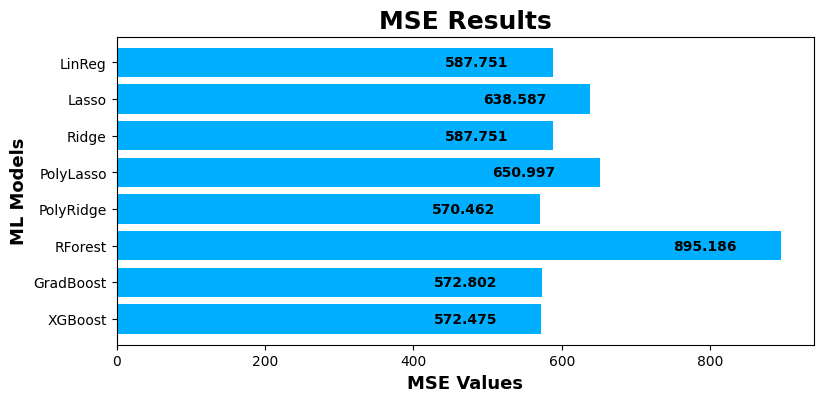

In [45]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'RForest', 'GradBoost', 'XGBoost']
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mse[i]-145, i+0.12, "{:.3f}".format(res_mse[i]), fontweight='bold')
plt.show()

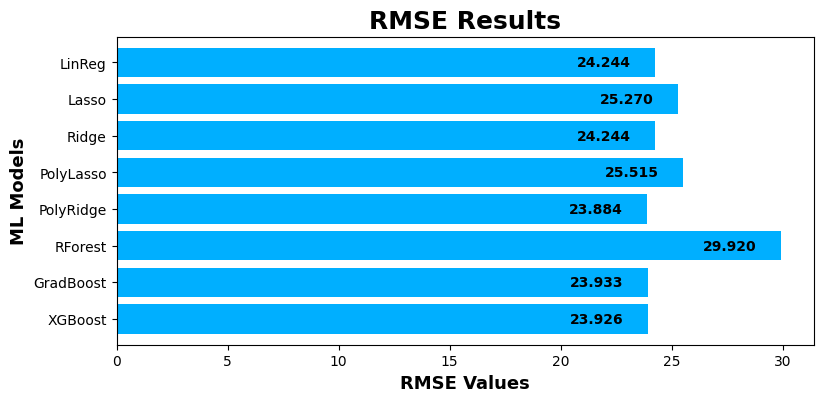

In [46]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_rmse[i]-3.5, i+0.12, "{:.3f}".format(res_rmse[i]), fontweight='bold')
plt.show()

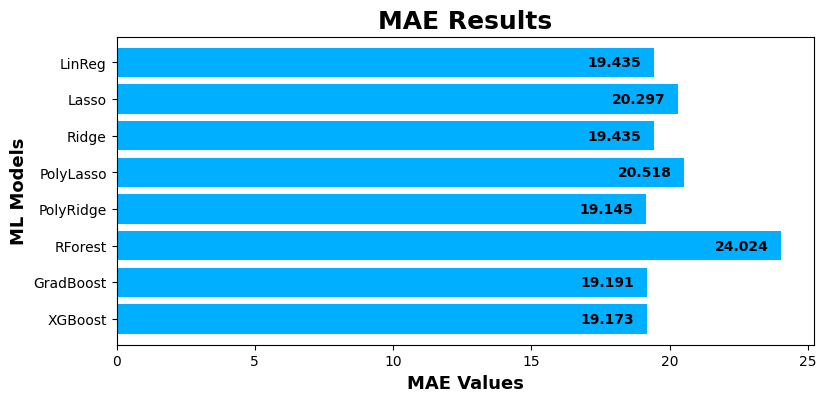

In [47]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mae[i]-2.4, i+0.12, "{:.3f}".format(res_mae[i]), fontweight='bold')
plt.show()

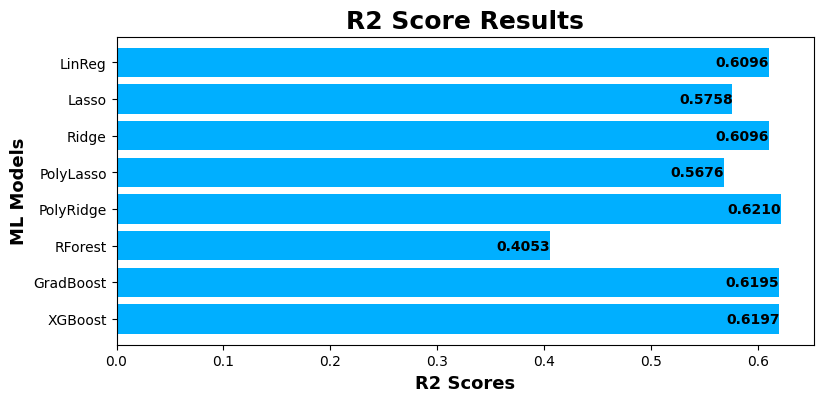

In [48]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_r2[i]-0.05, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

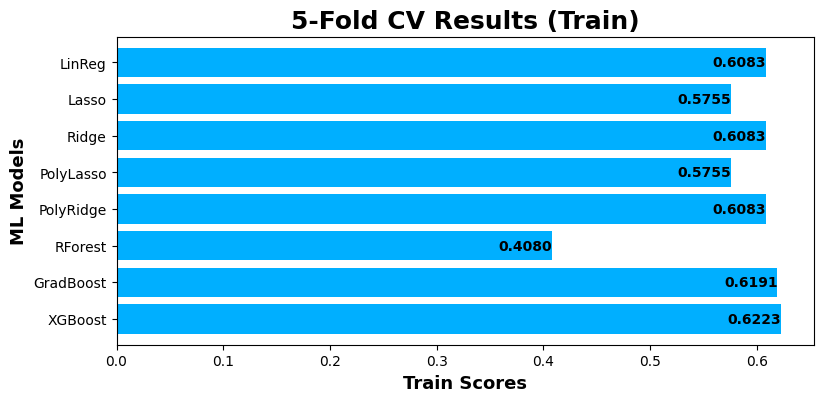

In [49]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_train[i]-0.05, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

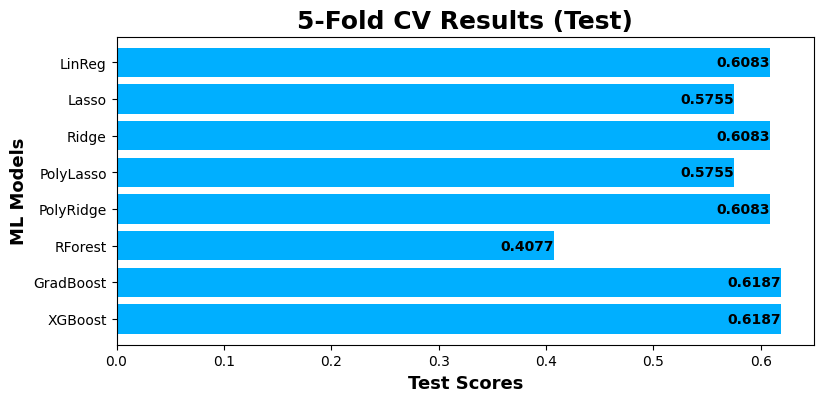

In [50]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_test[i]-0.05, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()